In [7]:
#system imports
import time
import sys
from sys import exit
import glob
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as pyfits
import matplotlib
import os
from astropy.visualization import (ImageNormalize,PercentileInterval,HistEqStretch)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gc 

# load the frame analysis code of eochar (from sps folder, no need to have it locally)
%run -i  /sps/lsst/users/antilog/GitHub/eochar/python/lsst/eochar/bot_frame_op.py

#selection of the .fits file
######method 1
#select one file by hand
#files_to_read='/sps/lsst/groups/FocalPlane/SLAC/run6/butler/import/calibs.20231017/u/plazas/DM-33657/biasGen.20220222.2/20220222T164636Z/bias/bias_LSSTComCam_R22_S00_u_plazas_DM-33657_biasGen_20220222_2_20220222T164636Z.fits'
files_to_read="/sps/lsst/groups/FocalPlane/SLAC/run6/butler/import/comcam_exposures/LSSTComCam/raw/all/raw/20220608/CC_O_20220608_000057/raw_LSSTComCam_r_03_CC_O_20220608_000057_R22_S00_LSSTComCam_raw_all.fits"
######method 2
#list of files
#run='13161'
#raft='R14'
#cd='S21'
#directory='dark_dark_*'
#file='MC_C_*_'+raft+'_'+ccd+'.fits'
#files_to_read='/sps/lsst/groups/FocalPlane/SLAC/run5/'+run+'/'+directory+'/'+file

file_list=glob.glob(files_to_read)
file_list.sort()
print('Selected files:')
print(file_list)

Selected files:
['/sps/lsst/groups/FocalPlane/SLAC/run6/butler/import/comcam_exposures/LSSTComCam/raw/all/raw/20220608/CC_O_20220608_000057/raw_LSSTComCam_r_03_CC_O_20220608_000057_R22_S00_LSSTComCam_raw_all.fits']


In [8]:
#compute unbiased image (used only for the image dimensions first)
UnBias='2D'
FileUnBias=InFile(dirall=file_list,Slow=False,verbose=False,Bias=UnBias) 

#get the image area ( overscan excluded ) using the first file 
first_col=FileUnBias.all_file[0].first_col
first_s_over=FileUnBias.all_file[0].first_s_over
first_line=FileUnBias.all_file[0].first_line
first_p_over=FileUnBias.all_file[0].first_p_over
amp_y_size=len(FileUnBias.all_file[0].Image[0][:,0])
amp_x_size=len(FileUnBias.all_file[0].Image[0][0,:])
im_y_size=first_p_over-first_line
im_x_size=first_s_over-first_col

print('Number of lines read=',amp_y_size,' Number of colomns read=',amp_x_size)
print('Number of lines in Image area=',im_y_size,' Number of colomns in Image area=',im_x_size)
print('First line in Image area=',first_line,' First column in Image area=',first_col)

Number of lines read= 2048  Number of colomns read= 576
Number of lines in Image area= 2000  Number of colomns in Image area= 509
First line in Image area= 0  First column in Image area= 3


In [11]:
###useful functions
def SaveFig(fig,rawPlotFile,run_cur='',raft_cur='',ccd_cur='',hdu=0):
    #if hdu<1 : 
    #    root_plt=os.path.join(output_data,run_cur,raft_cur,ccd_cur)
    #else : 
    #    hdu_cur='%d' % (hdu)
    #    root_plt=os.path.join(output_data,run_cur,raft_cur,ccd_cur,hdu_cur)
    # 
    #PlotFile=rawPlotFile.replace('.','_')
    #PlotFile=PlotFile.replace(' ','_')
    #os.makedirs(root_plt,exist_ok=True)
    #plotfile=os.path.join(root_plt,PlotFile)
    #print ('PlotFile=',plotfile)
    #fig.savefig(plotfile,bbox_inches='tight')
    #plt.close(fig) 
    return

def SingleImageIR(image,first_col=first_col,first_cover=first_s_over,first_line=first_line,first_lower=first_p_over):
        # Display an IR2 image , with amplifiers set at the right place ...there is a DM version which does this better...
        # but here you are in stand alone 
        # the default associated to the image area (pre-overscan excluded) are for e2v IR2 files 
        #
        col_size=first_cover-first_col
        line_size=first_lower-first_line
        #
        spf=np.zeros((line_size*2,col_size*8))
        for i in range(16) :
            if i<8 :
                xx=i*col_size-1
                yy=0
                for x in range(first_col,first_cover) :  
                    spf[yy:yy+line_size,xx+col_size-(x-first_col)]=image[i][first_line:first_lower,x]
            else :
                xx=(15-i)*col_size
                yy=-1
                for y in range(first_line,first_lower) :  
                    spf[yy+2*line_size-(y-first_line),xx:xx+col_size]=image[i][y,first_col:first_cover]
                    
        return spf
###end functions

In [20]:
#select first file
ifile=file_list[0]
    
#acces directly the fits file image 
fits=pyfits.open(ifile)

# print the image main information 
print(fits[1].header.tostring(sep='\n', endcard=True, padding=True))

XTENSION= 'IMAGE   '           / marks beginning of new HDU                     
BITPIX  =                   32 / bits per data value                            
NAXIS   =                    2 / number of axis                                 
NAXIS1  =                  576 / size of the n'th axis                          
NAXIS2  =                 2048 / size of the n'th axis                          
PCOUNT  =                    0 / Required value                                 
GCOUNT  =                    1 / Required value                                 
CHECKSUM= 'E5OXF3LVE3LVE3LV'   / checksum for the current HDU                   
CHANNEL =                    1                                                  
EXTNAME = 'Segment10'                                                           
CCDSUM  = '1 1     '                                                            
DATASEC = '[4:512,1:2000]'                                                      
DETSEC  = '[509:1,1:2000]'  

In [29]:
first_line, first_p_over

(0, 2000)

In [30]:
first_col, first_s_over

(3, 512)

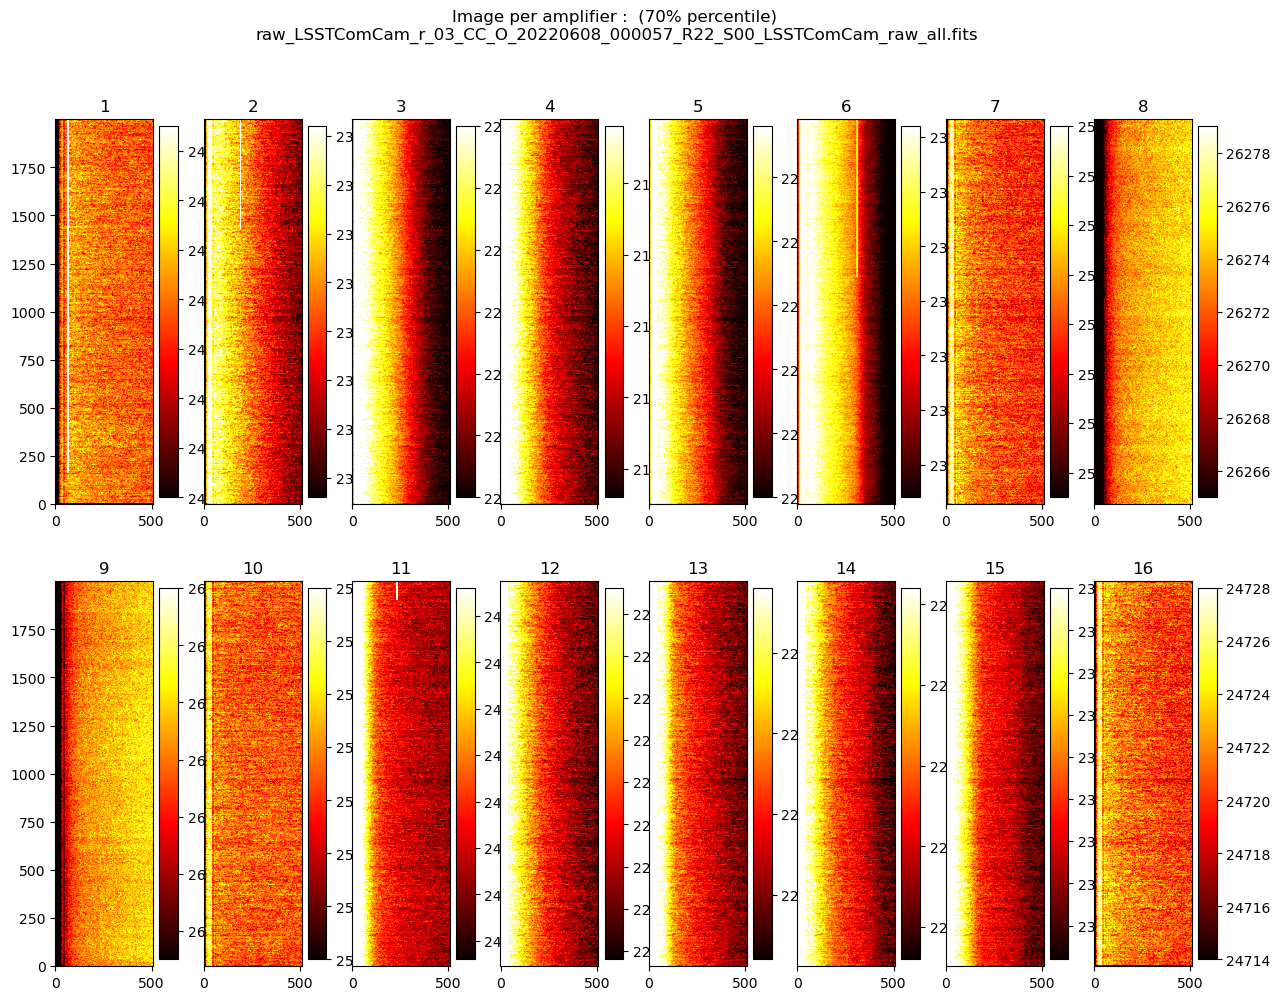

In [15]:
# plot the raw image / amplifier
fig=plt.figure(figsize=[15,11])
title='Image per amplifier :  (70%s percentile) \n%s' % ('%',os.path.basename(ifile))
image_txt='RawImagePerAmp'
plt.suptitle(title)
for i in range(16) :
    norm = ImageNormalize(fits[i+1].data[first_line:first_p_over,first_col:first_s_over], interval=PercentileInterval(70.))
    plt.subplot(2,8,i+1,title=i+1)
    plt.imshow(fits[i+1].data[first_line:first_p_over,first_col:first_s_over],cmap='hot',origin='lower',norm=norm)
    if not(i%8 ==0) :
        figure=plt.gca()
        y_axis = figure.axes.get_yaxis()
        y_axis.set_visible(False)
    plt.colorbar()
#SaveFig(fig,image_txt,run_cur=run,raft_cur=raft,ccd_cur=ccd,hdu=0)

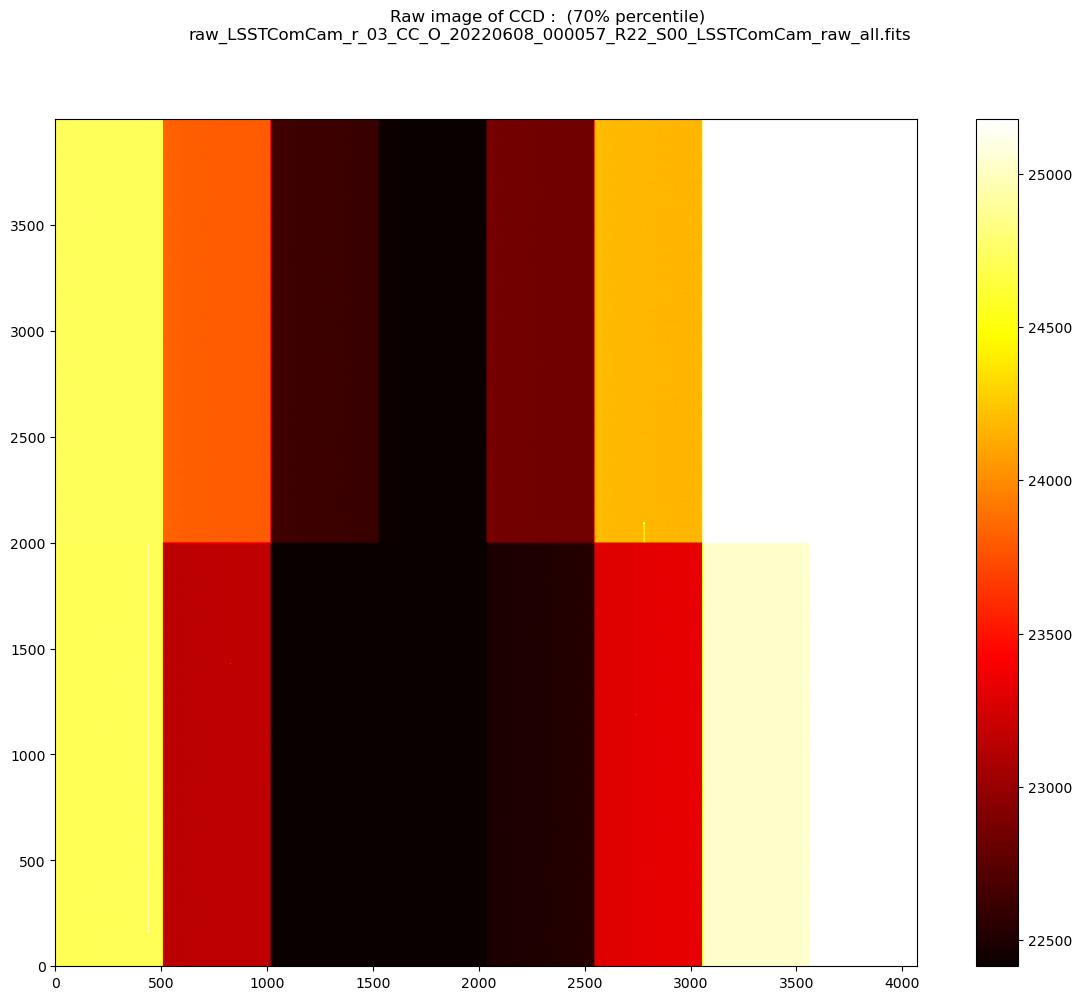

In [16]:
#plot all the amplifiers on one image (no overscan correction and no master bias substraction)
nb_amp=16

fig=plt.figure(figsize=[15,11])
title='Raw image of CCD :  (70%s percentile) \n%s' % ('%',os.path.basename(ifile))
plt.suptitle(title)

#create an image (fix the 0/1 index issue of the object fits)
image_tmp=[]
for i in range(nb_amp):
    image_tmp.append(fits[i+1].data)
    
image = SingleImageIR(image_tmp)
norm = ImageNormalize(image, interval=PercentileInterval(70.))
plt.imshow(image,cmap='hot',origin='lower',norm=norm)
plt.colorbar()
image_txt='CCD_RawImage'
#SaveFig(fig,image_txt,run_cur=run,raft_cur=raft,ccd_cur=ccd,hdu=0) 

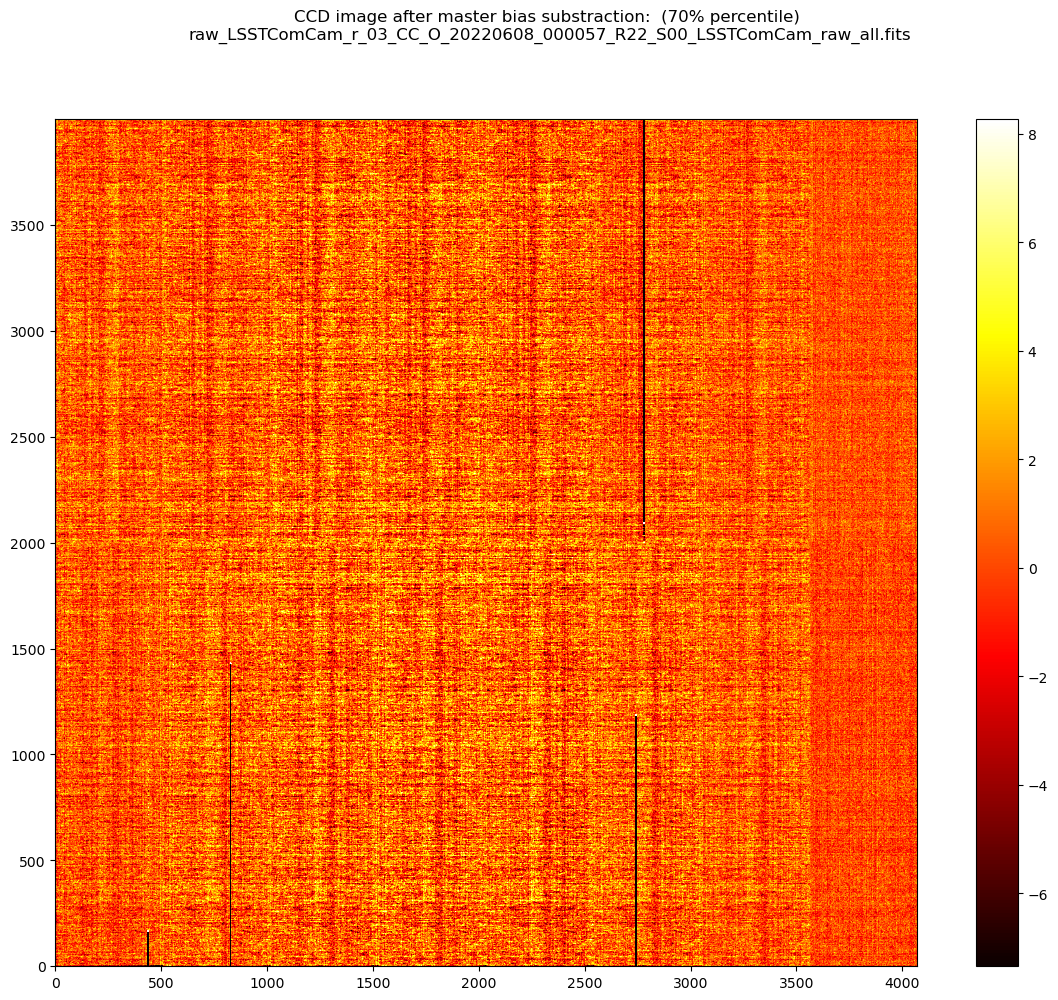

In [17]:
#plot all the amplifiers on one image after a master bias substraction
nb_amp=16

fig=plt.figure(figsize=[15,11])
title='CCD image after master bias substraction:  (70%s percentile) \n%s' % ('%',os.path.basename(ifile))
plt.suptitle(title)

image = SingleImageIR(FileUnBias.all_file[0].Image)
norm = ImageNormalize(image, interval=PercentileInterval(70.))
plt.imshow(image,cmap='hot',origin='lower',norm=norm)
plt.colorbar()
image_txt='CCD_Image'
#SaveFig(fig,image_txt,run_cur=run,raft_cur=raft,ccd_cur=ccd,hdu=0)

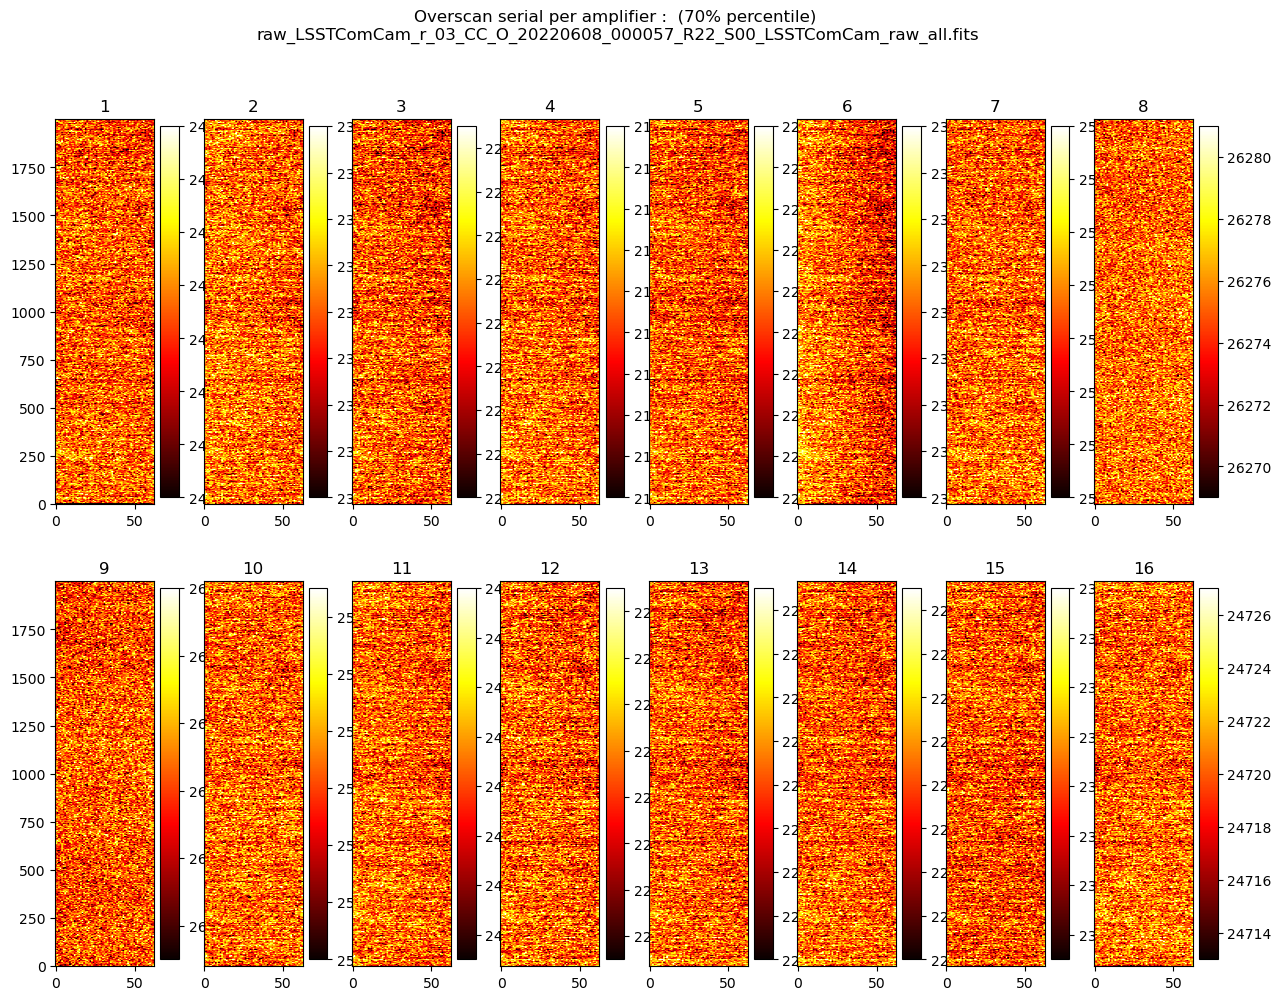

In [18]:
#access the serial overscan pixels   
fig=plt.figure(figsize=[15,11])
title='Overscan serial per amplifier :  (70%s percentile) \n%s' % ('%',os.path.basename(ifile))
image_txt='RawOverscanSerialPerAmp'
plt.suptitle(title)
for i in range(16) :
    norm = ImageNormalize(fits[i+1].data[first_line:first_p_over,first_s_over+1:amp_x_size], interval=PercentileInterval(70.))
    ax = plt.subplot(2,8,i+1,title=i+1)
    plt.imshow(fits[i+1].data[first_line:first_p_over,first_s_over+1:amp_x_size],cmap = 'hot',origin='lower',norm=norm)
    if not(i%8 ==0) :
        figure=plt.gca()
        y_axis = figure.axes.get_yaxis()
        y_axis.set_visible(False)
    plt.colorbar()
    ax.set_aspect('auto')
#SaveFig(fig,image_txt,run_cur=run,raft_cur=raft,ccd_cur=ccd,hdu=0)

(22300.0, 22500.0)

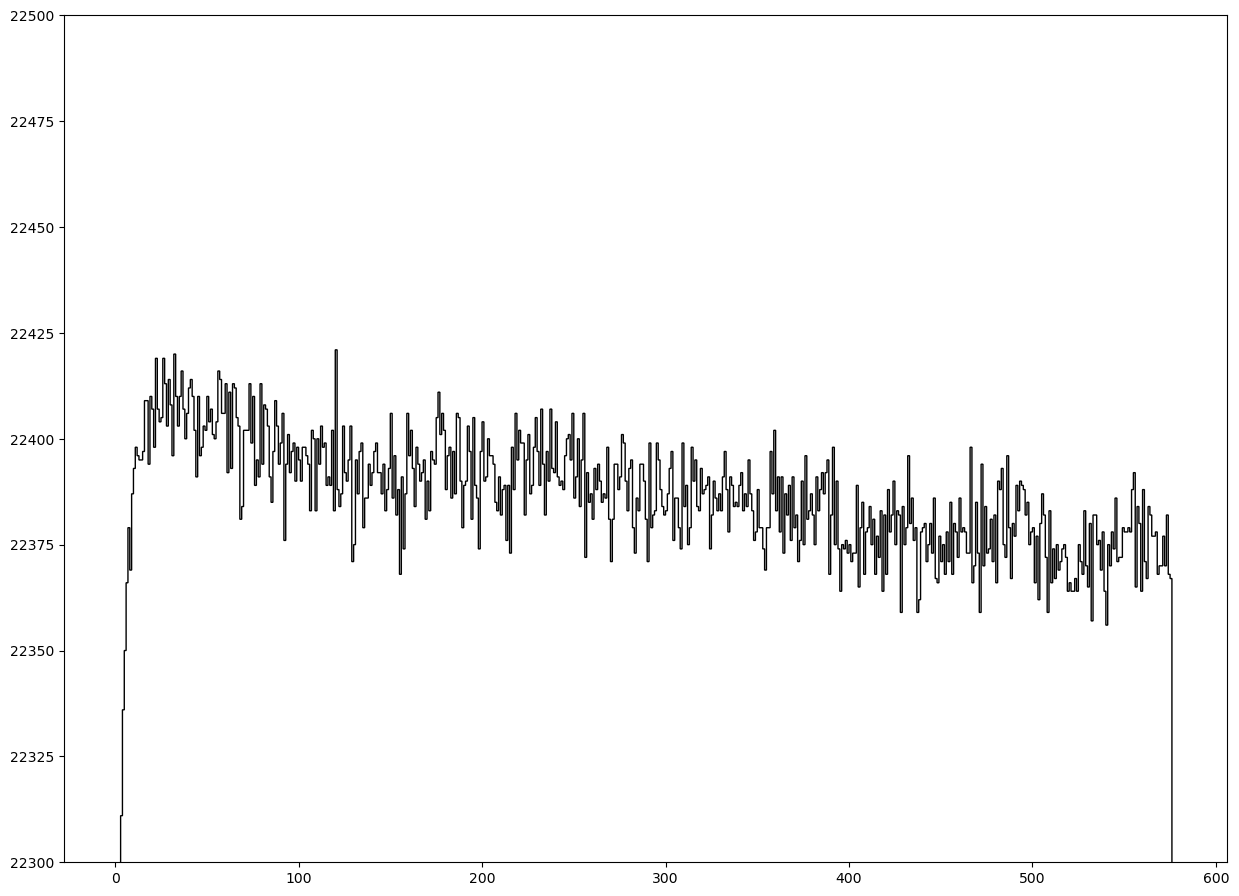

In [24]:
#1D distribution of a full line of one amplifier (including prescan and overscan regions)

#select line 750
line=fits[3].data[750,:]

n_bins=len(line)
bin_x=np.empty(n_bins)
xedges=np.empty(n_bins+1)
for ix in range(n_bins):
    bin_x[ix]=ix+0.5
    xedges[ix]=ix+1
xedges[n_bins]=n_bins+1

plt.figure(figsize=[15,11])
plt.hist(bin_x, weights=line, bins=xedges, histtype='step', color = 'black')
plt.ylim([22300, 22500])
#plt.savefig(output_data+'line_of_pixels.png') 

In [42]:
first_p_over

2000

In [43]:
amp_y_size

2048

In [37]:
first_col

3

In [40]:
first_s_over

512

In [41]:
amp_x_size

576

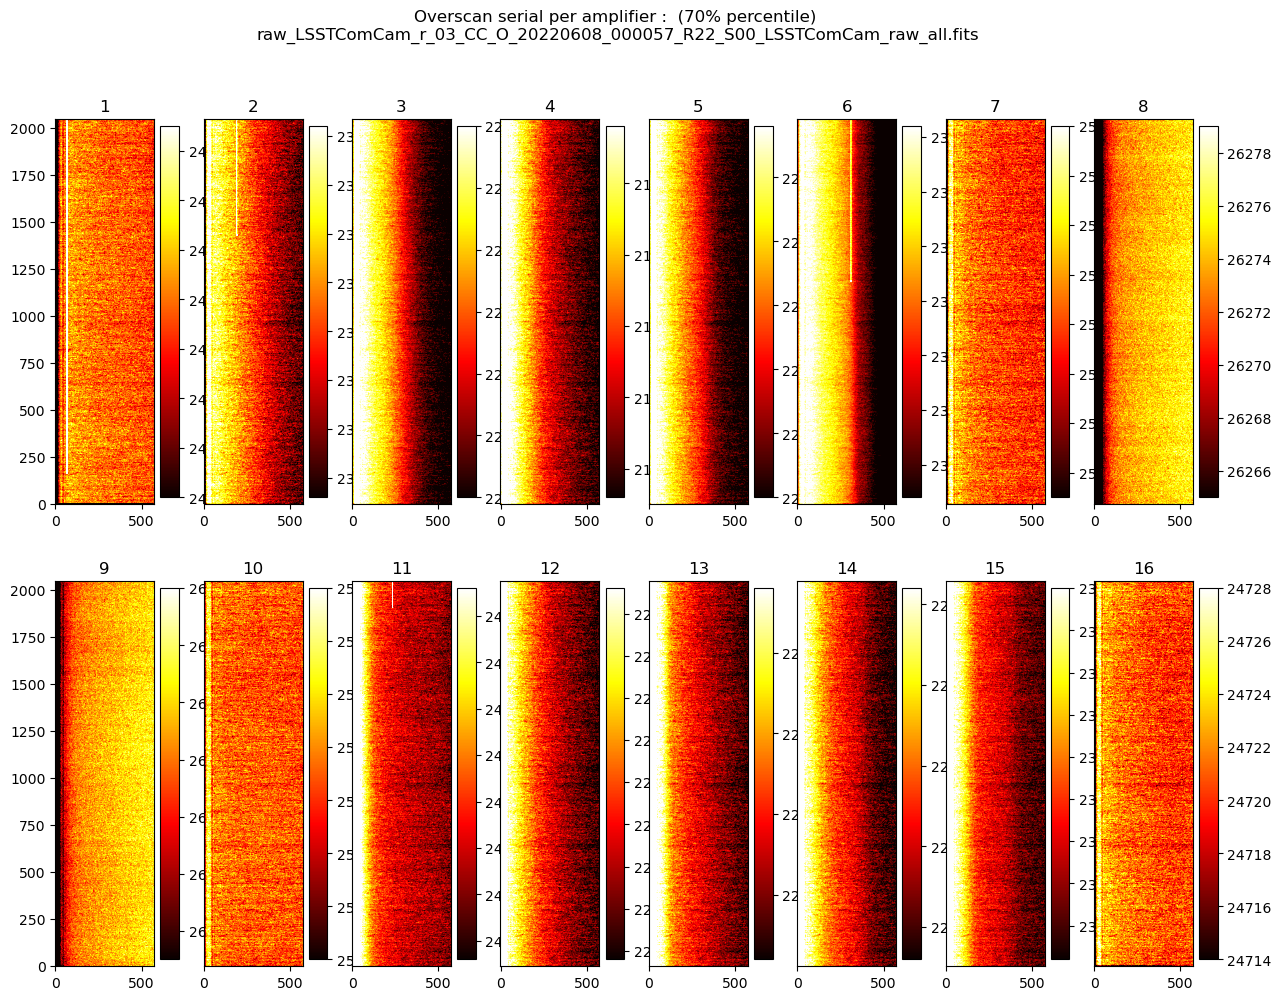

In [46]:
#access the serial overscan pixels   
fig=plt.figure(figsize=[15,11])
title='Overscan serial per amplifier :  (70%s percentile) \n%s' % ('%',os.path.basename(ifile))
image_txt='RawOverscanSerialPerAmp'
plt.suptitle(title)
for i in range(16) :
    norm = ImageNormalize(fits[i+1].data[first_line:first_p_over,first_col:first_s_over], interval=PercentileInterval(70.))
    ax = plt.subplot(2,8,i+1,title=i+1)
    plt.imshow(fits[i+1].data[first_line:amp_y_size,first_col:amp_x_size],cmap = 'hot',origin='lower',norm=norm)
    if not(i%8 ==0) :
        figure=plt.gca()
        y_axis = figure.axes.get_yaxis()
        y_axis.set_visible(False)
    plt.colorbar()
    ax.set_aspect('auto')
#SaveFig(fig,image_txt,run_cur=run,raft_cur=raft,ccd_cur=ccd,hdu=0)

In [69]:

mean_amp = []
for i in range(16) :
    for j in range(len(fits[i+1].data)):
        line=fits[i+1].data[j,:]
        mean.append(np.mean(line))
    mean_amp.append(mean)
    mean = []

In [76]:
len(mean_amp), len(mean_amp[0]), len(line)

(16, 2048, 576)

(array([1.000e+00, 1.000e+00, 3.460e+02, 1.699e+03, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([24663.26909722, 24677.9203125 , 24692.57152778, 24707.22274306,
        24721.87395833, 24736.52517361, 24751.17638889, 24765.82760417,
        24780.47881944, 24795.13003472, 24809.78125   ]),
 <BarContainer object of 10 artists>)

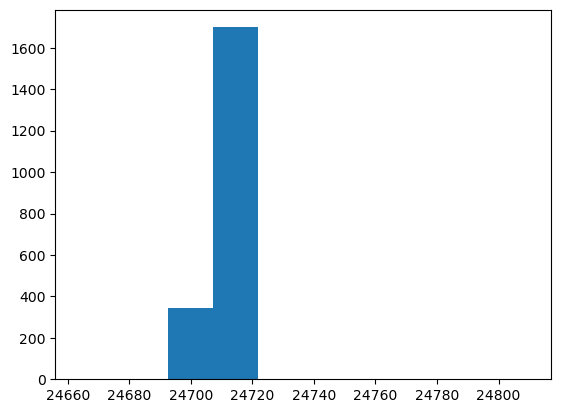

In [75]:
plt.hist(mean_amp[0], bins = 10)

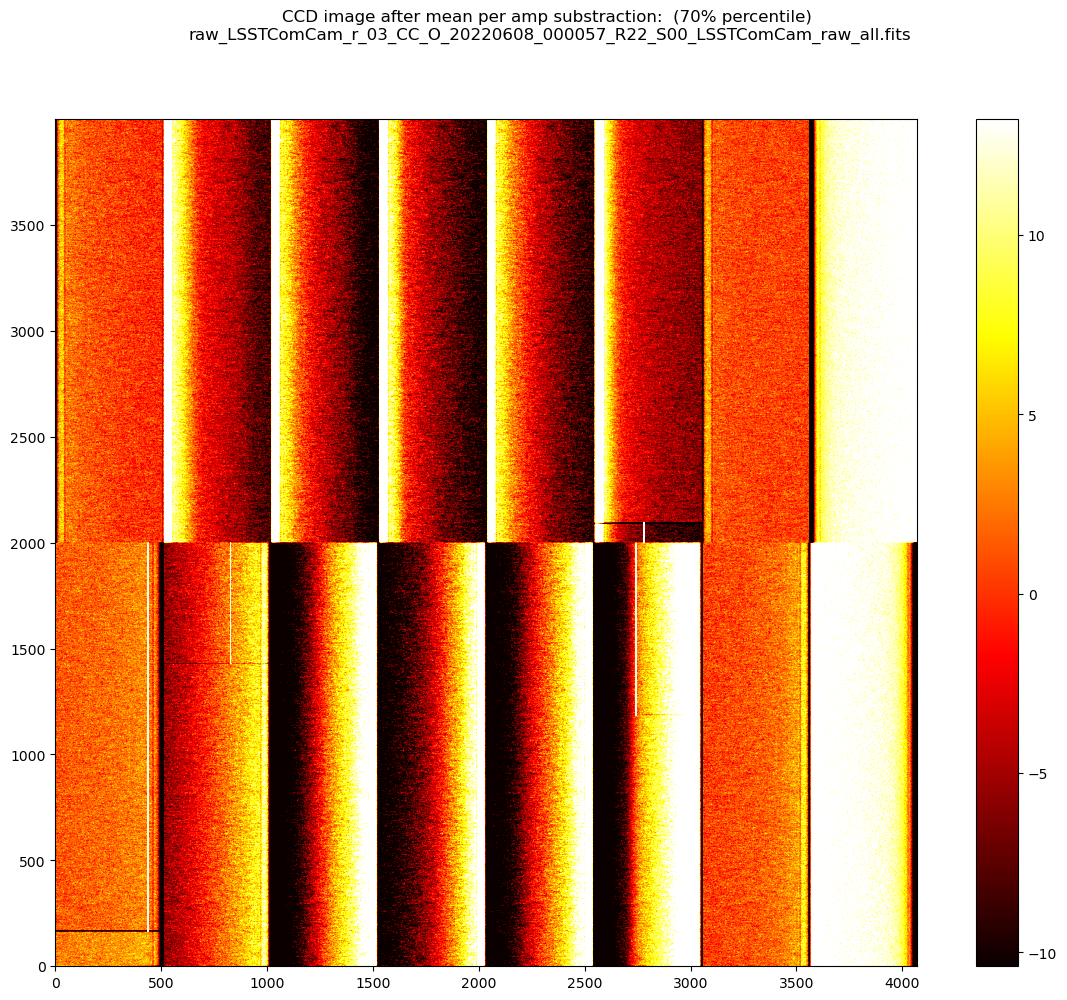

In [100]:
#plot all the amplifiers on one image after a master bias substraction
nb_amp=16

fig=plt.figure(figsize=[15,11])
title='CCD image after mean per amp substraction:  (70%s percentile) \n%s' % ('%',os.path.basename(ifile))
plt.suptitle(title)
data=np.empty([16,len(fits[1].data),len(fits[1].data[0])])
for i in range(16):
    for j in range(len(fits[i+1].data)):
        for k in range(len(fits[i+1].data[0])):
            data[i][j][k] = fits[i+1].data[j][k]-mean_amp[i][j]
image = SingleImageIR(data)
norm = ImageNormalize(image, interval=PercentileInterval(70.))
plt.imshow(image,cmap='hot',origin='lower',norm=norm)
plt.colorbar()
image_txt='CCD_Image'
    #SaveFig(fig,image_txt,run_cur=run,raft_cur=raft,ccd_cur=ccd,hdu=0)

In [97]:
mean_amp[0][0]

24663.269097222223

In [92]:
data

array([[4.68410024e-310, 4.68410300e-310, 4.68410024e-310, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       ...,
       [5.05268418e-310, 5.05289638e-310, 5.05332078e-310, ...,
        5.05204758e-310, 5.05056218e-310, 5.05119878e-310],
       [5.04950119e-310, 5.05247198e-310, 5.05416958e-310, ...,
        5.04992558e-310, 5.05098658e-310, 5.04971338e-310],
       [5.04928899e-310, 5.04865239e-310, 5.05162318e-310, ...,
        5.04822799e-310, 5.05162318e-310, 5.04865239e-310]])

In [95]:
fits[i+1].data[j]

array([25477, 23063, 24376, 24520, 24548, 24588, 24594, 24604, 24606,
       24615, 24629, 24638, 24645, 24647, 24636, 24653, 24650, 24656,
       24647, 24655, 24655, 24663, 24657, 24667, 24648, 24665, 24653,
       24648, 24666, 24661, 24646, 24645, 24668, 24665, 24664, 24658,
       24647, 24665, 24675, 24660, 24665, 24667, 24659, 24659, 24654,
       24660, 24664, 24653, 24671, 24677, 24655, 24664, 24652, 24666,
       24663, 24658, 24668, 24668, 24667, 24652, 24664, 24660, 24671,
       24660, 24679, 24671, 24658, 24658, 24668, 24662, 24671, 24659,
       24673, 24664, 24669, 24669, 24670, 24668, 24672, 24677, 24659,
       24658, 24660, 24676, 24663, 24664, 24677, 24676, 24674, 24668,
       24668, 24664, 24667, 24665, 24675, 24674, 24663, 24668, 24678,
       24653, 24678, 24682, 24674, 24660, 24674, 24668, 24677, 24670,
       24670, 24671, 24668, 24672, 24670, 24670, 24664, 24667, 24663,
       24670, 24679, 24653, 24683, 24667, 24672, 24668, 24666, 24664,
       24662, 24670,